# Step 1: Imports

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    precision_recall_curve, f1_score
)
import lightgbm as lgb
from category_encoders import TargetEncoder


# Step 2: Load dataset

In [3]:

train_path = '/kaggle/input/credit-card-fraud-detection/fraudTrain.csv'
test_path  = '/kaggle/input/credit-card-fraud-detection/fraudTest.csv'

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

print("Raw shapes -> train:", train.shape, " test:", test.shape)



Raw shapes -> train: (1296675, 23)  test: (555719, 23)


# Utility: fast vectorized haversine distance (km)

In [4]:

def haversine_vectorized(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius (km)
    lat1_r = np.radians(lat1)
    lon1_r = np.radians(lon1)
    lat2_r = np.radians(lat2)
    lon2_r = np.radians(lon2)
    dlat = lat2_r - lat1_r
    dlon = lon2_r - lon1_r
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1_r) * np.cos(lat2_r) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c



# Step 3: Impute missing numeric values (fit on train only)

In [5]:

num_cols = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long']
num_cols = [c for c in num_cols if c in train.columns]

num_imputer = SimpleImputer(strategy='mean')
train[num_cols] = num_imputer.fit_transform(train[num_cols])
test[num_cols]  = num_imputer.transform(test[num_cols])

print("After imputation -> train:", train.shape, " test:", test.shape)


After imputation -> train: (1296675, 23)  test: (555719, 23)


# Step 4: Feature engineering (temporal + distance) - vectorized

In [6]:

def add_time_and_geo_features(df):
    df = df.copy()
    # temporal
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['hour'] = df['trans_date_trans_time'].dt.hour.astype('int8')
    df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek.astype('int8')
    df['is_weekend'] = (df['day_of_week'] >= 5).astype('int8')
    df['season'] = (df['trans_date_trans_time'].dt.month % 12 // 3 + 1).astype('int8')
    # distance (vectorized)
    if {'lat','long','merch_lat','merch_long'}.issubset(df.columns):
        df['distance_km'] = haversine_vectorized(df['lat'], df['long'], df['merch_lat'], df['merch_long'])
    else:
        df['distance_km'] = 0.0
    # drop columns that leak identity or are high-cardinality free text
    drop_cols = [
        'trans_date_trans_time', 'first', 'last', 'street',
        'dob', 'trans_num', 'unix_time', 'merchant'
    ]
    drop_cols = [c for c in drop_cols if c in df.columns]
    df = df.drop(columns=drop_cols)
    return df

train = add_time_and_geo_features(train)
test  = add_time_and_geo_features(test)

print("After feature engineering -> train:", train.shape, " test:", test.shape)



After feature engineering -> train: (1296675, 20)  test: (555719, 20)


# Step 5: Define features and target

In [7]:

target_col = 'is_fraud'
exclude_cols = ['city', 'state', 'zip', 'job']  # optional excludes
features = [c for c in train.columns if c != target_col and c not in exclude_cols]
print("Number of features used:", len(features))



Number of features used: 15


In [8]:
# Step 6: Categorical encoding (TargetEncoder) - fit on train only
cat_cols = [c for c in ['category', 'gender'] if c in train.columns]
if len(cat_cols) > 0:
    te = TargetEncoder(cols=cat_cols, smoothing=0.3)
    train[cat_cols] = te.fit_transform(train[cat_cols], train[target_col])
    test[cat_cols]  = te.transform(test[cat_cols])
    print("Applied TargetEncoder to:", cat_cols)
else:
    print("No categorical columns to encode.")


Applied TargetEncoder to: ['category', 'gender']


# Step 7: Scale numeric features (fit on train only)

In [9]:

numeric_features = [c for c in ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'distance_km'] if c in train.columns]
scaler = StandardScaler()
if numeric_features:
    train[numeric_features] = scaler.fit_transform(train[numeric_features])
    test[numeric_features]  = scaler.transform(test[numeric_features])
    print("Scaled numeric features:", numeric_features)


Scaled numeric features: ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'distance_km']


# Step 8: Train/validation split (stratified)

In [10]:

X = train[features]
y = train[target_col].astype(int)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print("Train / Val shapes:", X_train.shape, X_val.shape, y_train.shape, y_val.shape)



Train / Val shapes: (1037340, 15) (259335, 15) (1037340,) (259335,)



# Step 9: Handle class imbalance (LightGBM: scale_pos_weight)
## - recommended: use scale_pos_weight instead of global SMOTE for very large datasets

In [11]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
print("Train class counts -> neg:", neg, " pos:", pos, " scale_pos_weight:", round(scale_pos_weight, 3))


Train class counts -> neg: 1031335  pos: 6005  scale_pos_weight: 171.746


# Step 9.5: Sanitize feature names for LightGBM

In [15]:

def sanitize_columns(df):
    return [col.replace(" ", "_")
               .replace("(", "")
               .replace(")", "")
               .replace("-", "_")
               .replace(":", "_")
            for col in df.columns]

X_train.columns = sanitize_columns(X_train)
X_val.columns   = sanitize_columns(X_val)


# Step 10: Build and train LightGBM model (fixed for Kaggle version)

In [16]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val   = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

params = {
    'objective': 'binary',
    'metric': ['auc', 'average_precision'],
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 64,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1,
    'seed': 42,
    'scale_pos_weight': scale_pos_weight
}

print("Starting LightGBM training...")
start = time.time()

bst = lgb.train(
    params,
    lgb_train,
    num_boost_round=2000,
    valid_sets=[lgb_train, lgb_val],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(100)   # log every 100 rounds
    ]
)

print("Training completed in {:.1f} sec".format(time.time() - start))

Starting LightGBM training...
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.999368	training's average_precision: 0.918413	valid_1's auc: 0.99761	valid_1's average_precision: 0.880036
[200]	training's auc: 0.99983	training's average_precision: 0.970889	valid_1's auc: 0.998338	valid_1's average_precision: 0.919714
[300]	training's auc: 0.999939	training's average_precision: 0.98835	valid_1's auc: 0.998581	valid_1's average_precision: 0.932581
[400]	training's auc: 0.99998	training's average_precision: 0.995906	valid_1's auc: 0.998813	valid_1's average_precision: 0.939467
[500]	training's auc: 0.999993	training's average_precision: 0.998623	valid_1's auc: 0.998955	valid_1's average_precision: 0.945788
[600]	training's auc: 0.999999	training's average_precision: 0.999687	valid_1's auc: 0.999015	valid_1's average_precision: 0.948755
[700]	training's auc: 0.999999	training's average_precision: 0.99983	valid_1's auc: 0.999146	valid_1's average_precision:

# Step 11: Evaluate on the (held-out) test set

In [17]:

# - We report PR-AUC (average precision) as primary metric
# - Also compute ROC-AUC, classification report, and threshold tuning (best F1)
# -------------------------------
X_test = test[features]
y_test = test[target_col].astype(int)

# predict probabilities
y_proba = bst.predict(X_test, num_iteration=bst.best_iteration)

# metrics
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc  = average_precision_score(y_test, y_proba)

print(f"ROC AUC: {roc_auc:.6f}")
print(f"PR AUC (avg precision): {pr_auc:.6f}")

# Find threshold that maximizes F1 on test (informative; you may choose different business threshold)
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
# compute f1 for thresholds (note thresholds length = len(precision)-1)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
best_idx = np.nanargmax(f1_scores[:-1])  # exclude last point which has undefined threshold
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
best_prec = precision[best_idx]
best_rec = recall[best_idx]

print(f"Best F1 on test = {best_f1:.4f} at threshold = {best_thresh:.4f}")
print(f"Precision@bestF1 = {best_prec:.4f}, Recall@bestF1 = {best_rec:.4f}")

# predictions at chosen threshold
chosen_threshold = best_thresh  # change this based on business need
y_pred = (y_proba >= chosen_threshold).astype(int)

print("\nClassification Report (threshold = {:.4f}):".format(chosen_threshold))
print(classification_report(y_test, y_pred, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



ROC AUC: 0.986794
PR AUC (avg precision): 0.719769
Best F1 on test = 0.6782 at threshold = 0.2012
Precision@bestF1 = 0.7327, Recall@bestF1 = 0.6312

Classification Report (threshold = 0.2012):
              precision    recall  f1-score   support

           0     0.9986    0.9991    0.9988    553574
           1     0.7327    0.6312    0.6782      2145

    accuracy                         0.9977    555719
   macro avg     0.8656    0.8152    0.8385    555719
weighted avg     0.9975    0.9977    0.9976    555719

Confusion Matrix:
[[553080    494]
 [   791   1354]]


# Step 12: Plot Precision-Recall curve and show threshold markers

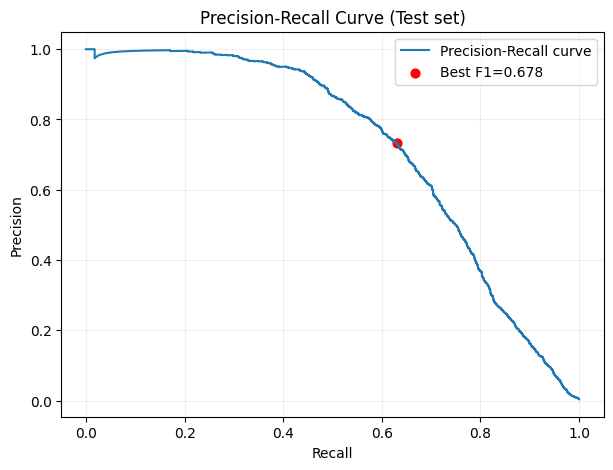

In [18]:

plt.figure(figsize=(7,5))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.scatter(best_rec, best_prec, color='red', s=40, label=f'Best F1={best_f1:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Test set)')
plt.legend()
plt.grid(alpha=0.2)
plt.show()


# Step 13: Save model and artifacts

In [19]:

bst.save_model('lgb_fraud_model.txt')
# Save the trained encoders/scalers & features if you need them later (optional)
import joblib
joblib.dump(num_imputer, 'num_imputer.pkl')
joblib.dump(te if 'te' in locals() else None, 'target_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(features, 'features_list.pkl')

print("Model and preprocessing artifacts saved.")

Model and preprocessing artifacts saved.
